In [1]:
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pandas as pd

In [2]:
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Sequential(nn.Flatten(), nn.Dropout(0.5))

In [3]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

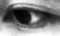

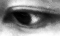

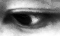

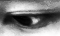

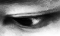

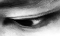

[None, None, None, None, None, None]

In [4]:
from zipfile import ZipFile
from PIL import Image
from glob import glob

image_list = []

subject_num = 20
batch_per_subject = 10

subject_list = np.repeat(np.arange(subject_num),batch_per_subject)

for data in glob("data/s*/synth/00[0-9]_left.zip"):

    with ZipFile(data) as archive:
        image_list.append([])
        for entry in archive.infolist():
            
            with archive.open(entry) as file:
                img = Image.open(file)
                image_list[-1].append(img)
                img.load()
                
list(map(display, image_list[0][-6:]))

In [5]:
gaze_list = []

for csv_file in glob("data/s*/synth/00[0-9]_left.csv"):
    gaze_list.append([])
    df = pd.read_csv(csv_file, header=None)
    gaze_list[-1].append(df[[0,1,2]].values)

gaze_list = np.array(gaze_list)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
device

device(type='cuda', index=0)

In [7]:

transform = transforms.Compose([
    transforms.ToTensor()
])

tensor_list = []

for image_group in image_list:
    image_tensor = [transform(i) for i in image_group]
    image_tensor = torch.cat(image_tensor).float()[:,None,...]
    image_tensor = image_tensor.repeat(1, 1, 3, 1, 1)
    tensor_list.append(image_tensor)
    
image_tensor = torch.concat(tensor_list)
image_tensor.shape

torch.Size([30, 144, 3, 36, 60])

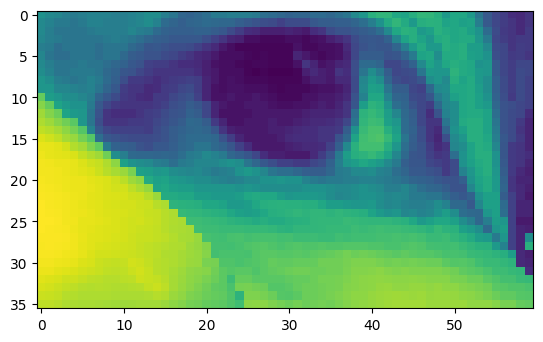

In [8]:
plt.imshow(image_tensor[0][0][0])

In [9]:
gaze_tensor = torch.concat([torch.tensor(i) for i in gaze_list]).float()
gaze_tensor.shape

torch.Size([200, 144, 3])

In [45]:
gaze_angles = torch.concat([torch.atan2(gaze_tensor[:,:,1], gaze_tensor[:,:,0])[..., None],
                            torch.acos(gaze_tensor[:,:,2])[..., None]], axis=2)
del gaze_tensor
gaze_angles.shape

torch.Size([200, 144, 2])

In [27]:
def pretrain(backbone):
    model = nn.Sequential(backbone, nn.Linear(512, 2, bias=False)).to(device)
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(5):
        for batch, gaze in zip(image_tensor, gaze_angles):
            optimizer.zero_grad()
            out = model(batch.to(device))
            loss = criterion(out, gaze.to(device))
            loss.backward()
            optimizer.step()
        print("Loss:", float(loss))

pretrain(resnet)
for param in resnet.parameters():
    param.requires_grad = False

Loss: 1.293459177017212
Loss: 1.6175585985183716
Loss: 1.443662166595459
Loss: 1.194016933441162
Loss: 0.9199007153511047


In [30]:
def train(backbone, n_epochs, train_data, train_label, subject_list):
    backbone.eval()
    sigma2 = 1
    SIGMA_u = torch.eye(512).to(device)
    
    fixed_effects = nn.Linear(512, 1, bias=False).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(fixed_effects.parameters())
    
    # Observation per batch
    n_i = train_data.shape[1]
    
    # Amount of batches
    n_batch = train_data.shape[0]
    
    # Amount of subjects
    n_sub = len(np.unique(subject_list))
    
    # Total of observations
    n = n_i * n_batch
    
    random_effects = [nn.Linear(512, 1, bias=False).to(device) for i in range(n_sub)]
    for coeff in random_effects:
        coeff.weight.data.fill_(0.0)
    
    I_n_i = torch.eye(n_i).to(device)
    for epoch in range(1, n_epochs + 1):
        
        # Train gamma & fixed effects
        fixed_effects.train()
        for i, batch in enumerate(train_data):
            optimizer.zero_grad()
            subject = subject_list[i]
            batch, y_i = batch.to(device), train_label[i].to(device)
            Gamma = backbone(batch).detach()
            y_i_random = random_effects[subject](Gamma)
            y_i_fixed = y_i - y_i_random
            loss = criterion(fixed_effects(Gamma), y_i_fixed)
            loss.backward()
            optimizer.step()
            
        sigma2_sum = 0
        SIGMA_u_sum = 0
        backbone.eval()
        fixed_effects.eval()
        with torch.no_grad():
            for i, batch in enumerate(train_data):
                batch, y_i = batch.to(device), train_label[i].to(device)

                subject = subject_list[i]

                # E-Step

                Gamma = backbone(batch).detach()
                y_i_fixed = fixed_effects(Gamma)

                V_i = Gamma @ SIGMA_u @ Gamma.T + (sigma2 * I_n_i)
                V_i_inv = torch.inverse(V_i)

                # U_i = random_effects.weight
                random_effects[subject].weight.data = (SIGMA_u @ Gamma.T @ V_i_inv @ (y_i - y_i_fixed)).T
                epsilon_i = y_i - y_i_fixed - random_effects[subject](Gamma)

                # M-step
                u_i = random_effects[subject].weight.data
                sigma2_sum += epsilon_i.T @ epsilon_i + sigma2 * (n_i - sigma2 * torch.trace(V_i_inv))
                SIGMA_u_sum += u_i.T @ u_i + (SIGMA_u - SIGMA_u @ Gamma.T @ V_i_inv @ Gamma @ SIGMA_u)

            sigma2 = sigma2_sum / n
            SIGMA_u = SIGMA_u_sum / n_batch

            loss_g = 0.0
        
            for i, batch in enumerate(train_data):
                batch, y_i = batch.to(device), train_label[i].to(device)
                subject = subject_list[i]
                Gamma = backbone(batch)
                y_i_fixed = fixed_effects(Gamma)
                y_i_random = random_effects[subject](Gamma)
                SIGMA_e = sigma2 * I_n_i
                u_i = random_effects[subject].weight.data.T
                error = y_i - y_i_fixed - y_i_random

                loss_g += float(error.T @ torch.inverse(SIGMA_e) @ error\
                         + u_i.T @ torch.inverse(SIGMA_u) @ u_i \
                         + torch.det(SIGMA_e) + torch.det(SIGMA_u))
        
        if epoch % 3 == 0:
            print("Epoch:", epoch, "Loss:", loss_g/n)
    
    return fixed_effects, random_effects

In [31]:
class RandomEffectsEstimation:

    def __init__(self, backbone, random_effects, train_data, subject_list):
        self.u_i = nn.Linear(512,512).to(device)
        self.u_i.train()
        backbone.eval()
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.u_i.parameters())
        
        for epoch in range(5):
            old_s = -1
            for i, batch in enumerate(train_data):
                subject = subject_list[i]
                
                with torch.no_grad():
                    X = backbone(batch.to(device))
                    if old_s != subject:
                        y = (random_effects[subject].weight.data.repeat(144, 1))
                        old_s = subject
                
                loss = criterion(self.u_i(X), y)
                loss.backward()
                optimizer.step()
                
        self.u_i.eval()

    def __call__(self, Gamma):
        h = nn.Linear(512,1, bias=False).to(device)
        h.weight.data = self.u_i(Gamma)
        return h(Gamma)


In [38]:
# Returns the angle between the two batch of vectors
def angular_difference(truth_batch, pred_batch):
    diff = 0
    for truth, pred in zip(truth_batch, pred_batch):
        theta_pred, phi_pred = pred[0], pred[1]
        theta_true, phi_true = truth[0], truth[1]
        
        dot_prod = torch.sin(theta_pred) * torch.sin(theta_true) \
                   * torch.cos(phi_pred - phi_true) + torch.cos(theta_pred)\
                   * torch.cos(theta_true)
        diff += torch.arccos(dot_prod) / np.pi * 180
        
    return diff / truth_batch.shape[0]

In [39]:
def cross_validation_menets(backbone, im_train, im_test, gaze_train, gaze_test, subjects):
    
    g_train = lambda x : gaze_train[:, :, x, None]
    
    fixed_effects, random_effects = zip(*[train(backbone, 10, im_train, g_train(i), subjects) for i in range(2)])
    
    backbone.eval()
    h = [RandomEffectsEstimation(resnet, random_effects[i], im_train, subjects) for i in range(2)]
    
    total_loss = 0.0
    
    with torch.no_grad():
        predict = torch.zeros(144, 2)
        for i, test in enumerate(im_test):
            Gamma = backbone(test.to(device))
            
            truth = gaze_test[i]
            for j in range(2):
                predict[:, j] = (fixed_effects[j](Gamma).cpu() + h[j](Gamma).cpu())[0]
                
            total_loss += angular_difference(truth, predict)
            
    return float(total_loss / im_test.shape[0])
        

In [40]:
n = subject_num

gaze_folds = (gaze_angles[:n // 3],
              gaze_angles[n // 3 : 2*n // 3],
              gaze_angles[2*n//3:])

im_folds = (image_tensor[:n // 3],
            image_tensor[n // 3 : 2*n // 3],
            image_tensor[2*n//3:])

subject_folds = (subject_list[:n // 3],
                subject_list[n // 3 : 2*n // 3],
                subject_list[2*n//3:])


error = cross_validation_menets(resnet,
                        torch.cat([im_folds[0], im_folds[1]], 0),
                        im_folds[2],
                        torch.cat([gaze_folds[0], gaze_folds[1]], 0),
                        gaze_folds[2],
                        np.concatenate([subject_folds[0], subject_folds[1]], axis=0))

error += cross_validation_menets(resnet,
                        torch.cat([im_folds[0], im_folds[2]], 0),
                        im_folds[1],
                        torch.cat([gaze_folds[0], gaze_folds[2]], 0),
                        gaze_folds[1],
                        np.concatenate([subject_folds[0], subject_folds[2]], axis=0))

error += cross_validation_menets(resnet,
                        torch.cat([im_folds[1], im_folds[2]], 0),
                        im_folds[0],
                        torch.cat([gaze_folds[1], gaze_folds[2]], 0),
                        gaze_folds[0],
                        np.concatenate([subject_folds[1], subject_folds[2]], axis=0))

print("3-fold cross validation for MeNets is: ", error / 3)

Epoch: 3 Loss: 9.67923190858629
Epoch: 6 Loss: 26.932605849372017
Epoch: 9 Loss: 64.91264290279813
Epoch: 3 Loss: 13.681227263477114
Epoch: 6 Loss: 174.89566729797258
Epoch: 9 Loss: 214.3527015182707
Epoch: 3 Loss: 10.413857798009996
Epoch: 6 Loss: 24.864280494236855
Epoch: 9 Loss: 45.79419248770937
Epoch: 3 Loss: 3.4999910583898024
Epoch: 6 Loss: 19.736984607360373
Epoch: 9 Loss: 61.37043328212139
Epoch: 3 Loss: 10.088916995059485
Epoch: 6 Loss: 23.65483413345512
Epoch: 9 Loss: 43.522153569364
Epoch: 3 Loss: 3.8133652479712534
Epoch: 6 Loss: 22.198024258988113
Epoch: 9 Loss: 68.8101158132955
3-fold cross validation for MeNets is:  91.82919565836589


In [43]:
def cross_validation_baseline(backbone, im_train, im_test, gaze_train, gaze_test, subjects):
    
    model = nn.Linear(512, 2, bias=False).to(device)
    backbone.train()
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(10):
        optimizer.zero_grad()
        for batch, gaze in zip(im_train, gaze_train):
            Gamma = backbone(batch.to(device)).detach()
            out = model(Gamma)
            loss = criterion(out, gaze.to(device))
            loss.backward()
            optimizer.step()
    
    total_loss = 0.0
    backbone.eval()
    model.eval()
    
    with torch.no_grad():
        for i, test in enumerate(im_test):
            Gamma = backbone(test.to(device)).detach()
            predict = model(Gamma).cpu()
            
            truth = gaze_test[i]
            total_loss += angular_difference(truth, predict)
    return float(total_loss / im_test.shape[0])

In [44]:
error = cross_validation_baseline(resnet,
                        torch.cat([im_folds[0], im_folds[1]], 0),
                        im_folds[2],
                        torch.cat([gaze_folds[0], gaze_folds[1]], 0),
                        gaze_folds[2],
                        np.concatenate([subject_folds[0], subject_folds[1]], axis=0))

error += cross_validation_baseline(resnet,
                        torch.cat([im_folds[0], im_folds[2]], 0),
                        im_folds[1],
                        torch.cat([gaze_folds[0], gaze_folds[2]], 0),
                        gaze_folds[1],
                        np.concatenate([subject_folds[0], subject_folds[2]], axis=0))

error += cross_validation_baseline(resnet,
                        torch.cat([im_folds[1], im_folds[2]], 0),
                        im_folds[0],
                        torch.cat([gaze_folds[1], gaze_folds[2]], 0),
                        gaze_folds[0],
                        np.concatenate([subject_folds[1], subject_folds[2]], axis=0))

print("3-fold cross validation for ResNet baseline is: ", error / 3)

3-fold cross validation for ResNet baseline is:  55.25474294026693
